In [ ]:
# %%

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import pickle

from qiskit_aer import Aer

from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator, StatevectorSampler
from qiskit_aer.primitives import EstimatorV2
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qapplib.ml.transformers import (
    ProjectedQuantumFeatures,
    ShuffleFeatures,
    PickleFeatures,
)
from qapplib.circuit.library import (
    SeparateEntangleFeatureMap,
    HeisenbergHamiltonianFeatureMap,
)

from sklearn.datasets import make_classification
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    StratifiedShuffleSplit,
)
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_curve,
    roc_auc_score,
)

from qmlkit.model_selection import GridSearchCV
from qmlkit.transformers.ray_batch import RayBatchWrapperTransformer
from qmlkit.evaluation import evaluate_with_hpo

from file_util import move_folder_to_backup

In [ ]:
# %%

X, y = make_classification(
    1000, 9, random_state=137, n_clusters_per_class=3, n_informative=5, n_redundant=2
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=100, random_state=42, stratify=y
)

In [ ]:
# %%

# Transform data up front once for simplicity:
mms = MinMaxScaler((0.3, 2.8))
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [ ]:
# %%

# Using fewer qubits for fast simulation and to immitate the larger scale problems we have, and also
# make the right feature map more important
n_qubits = 4

backend = AerSimulator(method="statevector", precision="single")


# Define the AerSimulator with the statevector method
# backend = Aer.get_backend('aer_simulator_statevector')
# backend.set_options(max_parallel_threads=1)

# StatevectorSampler()
# backend = StatevectorSimulator(precision='single')

In [ ]:
# %%

# ## Get results without optimizing the feature map (use defaultfixed heisenberg)
# See results first, without any optimization of the circuit

ckpt_folder = "pqfm_checkpoint"

tmp_dir = "/home/brian-quanz/data/tmp"

# Move checkpoint folder to clear precomputed results with same circuit
# move_folder_to_backup(ckpt_folder,'backup')


pqfm = ProjectedQuantumFeatures(
    feature_map=HeisenbergHamiltonianFeatureMap(
        n_qubits,
        feature_dimension=X_train.shape[1],
        init_state="random",
        random_seed=1,
        alpha=0.5,
        blocks=1,
        entanglement="pairwise",
    ),
    observables="one",
    backend=backend,
    encoding="measurement",
    folder_name=ckpt_folder,
    job_size=10,
)


start = time.time()
X_train_pqfm = pqfm.fit_transform(X_train)
end = time.time()
print("PQFM train time:", end - start)
start = time.time()
X_test_pqfm = pqfm.transform(X_test)
end = time.time()
print("PQFM test time:", end - start)

PQFM train time: 1.0122852325439453
PQFM test time: 1.0064632892608643


In [ ]:
# %%

params = {
    "max_depth": [3, 5, 7],
    "n_estimators": [200, 300],
    "learning_rate": [0.3, 0.03, 0.003],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1],
    "gamma": [0.0, 0.1, 1.0, 10.0],
}
n_jobs = 50


hpo_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=1)

xgb_model = GridSearchCV(
    XGBClassifier(random_state=1, objective="binary:logistic", nthread=1),
    hpo_splitter=hpo_splitter,
    scoring="roc_auc",
    n_jobs=n_jobs,  # Comment out if on QMAT server
    ray_init_kwargs={"_temp_dir": tmp_dir},
    param_grid=params,
    verbose=2,
)
xgb_model.fit(X_train_pqfm, y_train)

# Get the test predictions of the classical model, and scores for comparison and diversity comp.
test_probs = xgb_model.predict_proba(X_test_pqfm)[:, 1]
train_probs = xgb_model.predict_proba(X_train_pqfm)[:, 1]
test_preds = xgb_model.predict(X_test_pqfm)
train_preds = xgb_model.predict(X_train_pqfm)
auc = roc_auc_score(y_test, test_probs)
auc_train = roc_auc_score(y_train, train_probs)

acc = accuracy_score(y_test, test_preds)
acc_train = accuracy_score(y_train, train_preds)

# AUC test: 0.7192813507760838 train: 1.0
# Acc test: 0.6511111111111111 train: 1.0
print("AUC test:", auc, "train:", auc_train)
print("Acc test:", acc, "train:", acc_train)

Fitting and scoring for 6 data splits and 288 hyper params
Starting local ray cluster with 50 CPUs


2025-01-28 22:27:46,197	INFO worker.py:1821 -- Started a local Ray instance.


Running in parallel with 50.0 CPUs


  0% (0 of 1440) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (3 of 1440) |                       | Elapsed Time: 0:00:00 ETA:   0:01:13
  0% (10 of 1440) |                      | Elapsed Time: 0:00:00 ETA:   0:00:37
  1% (19 of 1440) |                      | Elapsed Time: 0:00:00 ETA:   0:00:26
  2% (34 of 1440) |                      | Elapsed Time: 0:00:00 ETA:   0:00:19
  3% (51 of 1440) |                      | Elapsed Time: 0:00:00 ETA:   0:00:15
  5% (73 of 1440) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:12
  6% (92 of 1440) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:11
  7% (110 of 1440) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:10
  8% (128 of 1440) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:09
 10% (146 of 1440) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:08
 12% (183 of 1440) |##                   | Elapsed Time: 0:00:01 ETA:   0:00:07
 15% (219 of 1440) |###                 

Best hyper params: {None: {0: {'test_scores': None, 'train_scores': None, 'hpo_score_stats': (np.float64(0.782), np.float64(0.13029197979921864)), 'best_param_idx': 182, 'best_params': {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}}}}
Fitting and scoring for train-test splits and best hyper params


  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


AUC test: 0.7295188428127669 train: 1.0
Acc test: 0.6677777777777778 train: 1.0


In [ ]:
# %%

# Can also check classical:

# hpo_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# # StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=1)

# xgb_model = GridSearchCV(
#     XGBClassifier(random_state=1, objective="binary:logistic", nthread=1),
#     hpo_splitter=hpo_splitter,
#     scoring="roc_auc",
#     n_jobs=n_jobs,  # Comment out if on QMAT server
#     param_grid=params,
#     verbose=2,
# )
# xgb_model.fit(X_train, y_train)

# # Get the test predictions of the classical model, and scores for comparison and diversity comp.
# test_probs = xgb_model.predict_proba(X_test)[:, 1]
# train_probs = xgb_model.predict_proba(X_train)[:, 1]
# test_preds = xgb_model.predict(X_test)
# train_preds = xgb_model.predict(X_train)
# auc = roc_auc_score(y_test, test_probs)
# auc_train = roc_auc_score(y_train, train_probs)

# acc = accuracy_score(y_test, test_preds)
# acc_train = accuracy_score(y_train, train_preds)

# # AUC test: 0.8707251186472486 train: 0.9975999999999999
# # Acc test: 0.7955555555555556 train: 0.98
# print("AUC test:", auc, "train:", auc_train)
# print("Acc test:", acc, "train:", acc_train)

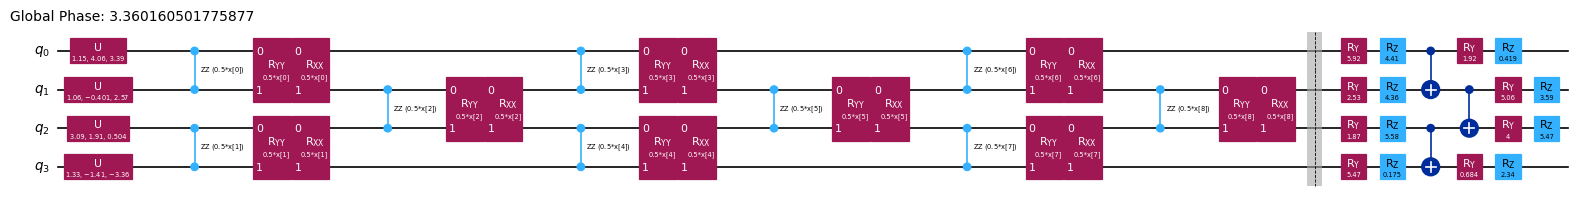

In [ ]:
# %%

# Check process to build combined circuit:

# Build a combined circuit
qc = QuantumCircuit(n_qubits)

qc.compose(
    HeisenbergHamiltonianFeatureMap(
        n_qubits,
        feature_dimension=X_train.shape[1],
        init_state="random",
        random_seed=1,
        alpha=0.5,
        blocks=1,
        entanglement="pairwise",
    ),
    range(n_qubits),
    inplace=True,
)
qc.barrier(range(n_qubits))

param_ansatz = EfficientSU2(
    n_qubits, reps=1, parameter_prefix="θ", entanglement="pairwise"
)
num_params = len(param_ansatz.parameters)

v_params = np.random.rand(num_params) * 2 * np.pi

bound_circuit = param_ansatz.assign_parameters(v_params)
qc.compose(bound_circuit, range(n_qubits), inplace=True)
qc = qc.decompose()
qc.draw("mpl", scale=0.6, fold=-1)

In [ ]:
# %%

print(num_params)

16


In [ ]:
# %%

# Check evaluation scoring process

# xgb_model = XGBClassifier(random_state=1, objective="binary:logistic", nthread=1)
# hpo_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=1)
# eval_splitter = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
# # eval_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=1)

# result_summary, result_details = evaluate_with_hpo(
#     xgb_model,
#     X_train_pqfm,
#     y_train,
#     evaluation_splitter=eval_splitter,
#     hpo_splitter=hpo_splitter,
#     scoring="roc_auc",
#     n_jobs=n_jobs,  # Comment out if on QMAT server
#     ray_init_kwargs={"_temp_dir": tmp_dir},
#     param_grid=params,
#     verbose=0,
# )

# result_summary['test']['mean']

In [ ]:
# %%

ckpt_folder = "pqfm_checkpoint_opt"
# Define combined circuit and objective function


def build_combined_circuit(v_params):
    # Function to build the combined circuit, given a set of parameters
    qc = QuantumCircuit(n_qubits)

    qc.compose(
        HeisenbergHamiltonianFeatureMap(
            n_qubits,
            feature_dimension=X_train.shape[1],
            init_state="random",
            random_seed=1,
            alpha=0.5,
            blocks=1,
            entanglement="pairwise",
        ),
        range(n_qubits),
        inplace=True,
    )

    param_ansatz = EfficientSU2(
        n_qubits, reps=1, parameter_prefix="θ", entanglement="pairwise"
    )

    bound_circuit = param_ansatz.assign_parameters(v_params)
    qc.compose(bound_circuit, range(n_qubits), inplace=True)
    qc = qc.decompose()

    return qc


# Define objective function
def obj_func(v_params):
    # Objective function to optimize - a function of the parameters
    qc = build_combined_circuit(v_params)

    # Remove old checkpoint from previous opt. iteration
    move_folder_to_backup(ckpt_folder, "backup")

    # Transform the data given current circuit:
    pqfm = ProjectedQuantumFeatures(
        feature_map=qc,
        observables="one",
        backend=backend,
        encoding="measurement",
        folder_name=ckpt_folder,
        job_size=10,
    )

    X_train_pqfm = pqfm.fit_transform(X_train)

    xgb_model = XGBClassifier(random_state=1, objective="binary:logistic", nthread=1)
    hpo_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=1)
    eval_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # eval_splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=1)

    result_summary, _ = evaluate_with_hpo(
        xgb_model,
        X_train_pqfm,
        y_train,
        evaluation_splitter=eval_splitter,
        hpo_splitter=hpo_splitter,
        scoring="roc_auc",
        n_jobs=n_jobs,  # Comment out if on QMAT server
        param_grid=params,
        verbose=0,
    )

    score = result_summary["test"]["mean"]

    # Want to maximize the score (AUC) - so for minimization, need to return negative:
    return -score

In [ ]:
# %%

# Define evaluation function - get test scores once we have specified
# the specific params:


def test_scores(v_params):
    # Objective function to optimize - a function of the parameters
    qc = build_combined_circuit(v_params)

    # Remove old checkpoint from previous opt. iteration
    move_folder_to_backup(ckpt_folder, "backup")

    # Transform the data given current circuit:
    pqfm = ProjectedQuantumFeatures(
        feature_map=qc,
        observables="one",
        backend=backend,
        encoding="measurement",
        folder_name=ckpt_folder,
        job_size=10,
    )

    X_train_pqfm = pqfm.fit_transform(X_train)
    X_test_pqfm = pqfm.transform(X_test)

    hpo_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=1)

    xgb_model = GridSearchCV(
        XGBClassifier(random_state=1, objective="binary:logistic", nthread=1),
        hpo_splitter=hpo_splitter,
        scoring="roc_auc",
        n_jobs=n_jobs,  # Comment out if on QMAT server
        ray_init_kwargs={"_temp_dir": tmp_dir},
        param_grid=params,
        verbose=1,
    )
    xgb_model.fit(X_train_pqfm, y_train)

    # Get the test predictions of the classical model, and scores for comparison and diversity comp.
    test_probs = xgb_model.predict_proba(X_test_pqfm)[:, 1]
    train_probs = xgb_model.predict_proba(X_train_pqfm)[:, 1]
    test_preds = xgb_model.predict(X_test_pqfm)
    train_preds = xgb_model.predict(X_train_pqfm)
    auc = roc_auc_score(y_test, test_probs)
    auc_train = roc_auc_score(y_train, train_probs)

    acc = accuracy_score(y_test, test_preds)
    acc_train = accuracy_score(y_train, train_preds)

    # AUC test: 0.7192813507760838 train: 1.0
    # Acc test: 0.6511111111111111 train: 1.0
    print("AUC test:", auc, "train:", auc_train)
    print("Acc test:", acc, "train:", acc_train)

    return auc, auc_train, acc, acc_train

In [ ]:
# %%

# Let's evaluate for random assignment of values:
np.random.seed(0)
v_params = np.random.rand(num_params) * 2 * np.pi
start = time.time()
f_obj = obj_func(v_params)
end = time.time()

print("Fobj for rand params:", f_obj, "Time to compute:", end - start)

Fobj for rand params: -0.6699999999999999 Time to compute: 25.0193030834198


In [ ]:
# %%

# Try different optimizers - e.g., Bayesian optimization, SPSA, CD
# Let's start with BO...
from skopt import gp_minimize

# Define the search space with real value variables
dimensions = [(0.0, 2 * np.pi)] * num_params

# Perform Bayesian optimization
result = gp_minimize(
    func=obj_func,
    dimensions=dimensions,
    n_calls=100,  # Number of optimization iterations
    random_state=0,
    verbose=True,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 26.7175
Function value obtained: -0.7720
Current minimum: -0.7720
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 29.6778
Function value obtained: -0.7220
Current minimum: -0.7720
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 27.0417
Function value obtained: -0.7020
Current minimum: -0.7720
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 28.1841
Function value obtained: -0.7310
Current minimum: -0.7720
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 26.7156
Function value obtained: -0.6830
Current minimum: -0.7720
Iteration No: 6 star

In [ ]:
# %%

with open("results/toy_100n_4q_opt_gpbo_results.pkl", "wb") as ofile:
    pickle.dump(result, ofile)

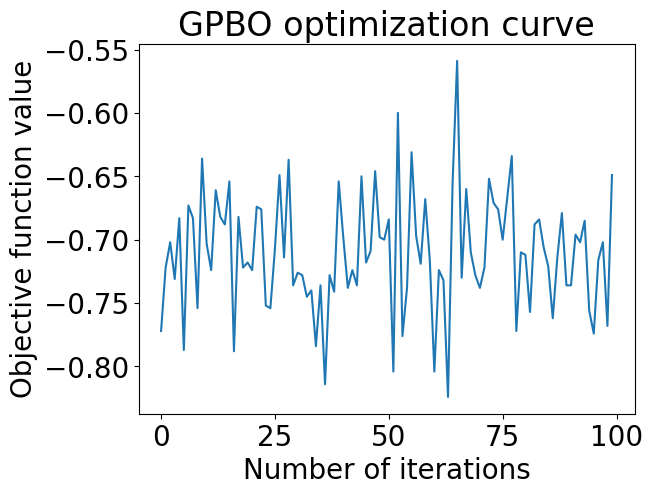

In [ ]:
# %%

# Plot obj func for GBPO vs. iterations
plt.rcParams.update({"font.size": 20})

os.makedirs("figs", exist_ok=True)
plt.plot(result.func_vals)
plt.xlabel("Number of iterations")
plt.ylabel("Objective function value")
plt.title("GPBO optimization curve")
plt.savefig("figs/toy_100n_4q_opt_gpbo_opt_curve.jpg", bbox_inches="tight")

In [ ]:
# %%

# Get scores for current GPBO result:
v_params = result.x

test_scores(v_params)

Fitting and scoring for 6 data splits and 288 hyper params
Running in parallel with 50.0 CPUs
Fitting and scoring for train-test splits and best hyper params
AUC test: 0.7554508595443749 train: 0.9987999999999999
Acc test: 0.6955555555555556 train: 0.96


(np.float64(0.7554508595443749),
 np.float64(0.9987999999999999),
 0.6955555555555556,
 0.96)

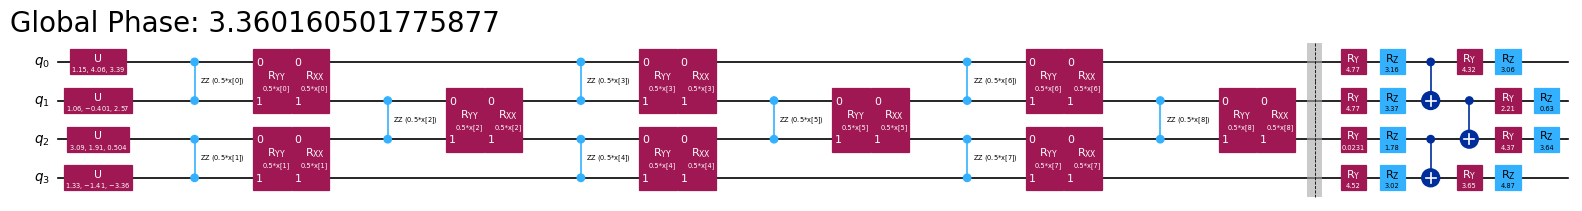

In [ ]:
# %%

# See final circuit
qc = build_combined_circuit(v_params, barrier=True)

qc.draw("mpl", scale=0.6, fold=-1, filename="figs/toy_100n_4q_gpbo_opt_circ.jpg")

In [ ]:
# %%

# Can we improve this more with CD?
from opt import coordinate_descent_with_linesearch

os.makedirs("intermediate", exist_ok=True)

lower_bound = np.array([0] * num_params)
upper_bound = np.array([2 * np.pi] * num_params)

# Changed name to not over-write existing results
x, fval_history, x_history = coordinate_descent_with_linesearch(
    obj_func,
    x_init=np.array(v_params.copy()),
    max_iter=10,
    tol=1e-2,
    save_details_path="intermediate/cd_progress.npz",
    verbose=1,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
)

with open("results/toy_100n_4q_opt_cd_after_gpbo_results.pkl", "wb") as ofile:
    pickle.dump((x, fval_history, x_history), ofile)

Start score: -0.7700000000000001
Iter:0
   p:0 fval:-0.8300000000000001
   p:1 fval:-0.8300000000000001
   p:2 fval:-0.842
   p:3 fval:-0.842
   p:4 fval:-0.858
   p:5 fval:-0.858
   p:6 fval:-0.858
   p:7 fval:-0.858
   p:8 fval:-0.858
   p:9 fval:-0.866
   p:10 fval:-0.866
   p:11 fval:-0.866
   p:12 fval:-0.866
   p:13 fval:-0.866
   p:14 fval:-0.866
   p:15 fval:-0.866
Iter:1
   p:0 fval:-0.866
   p:1 fval:-0.866
   p:2 fval:-0.8800000000000001
   p:3 fval:-0.8800000000000001
   p:4 fval:-0.8800000000000001
   p:5 fval:-0.8800000000000001
   p:6 fval:-0.8800000000000001
   p:7 fval:-0.8800000000000001


KeyboardInterrupt: 

In [ ]:
# %%

# Terminated early as no further progress was seeming to be made
# Load best result
save_details_path = "intermediate/cd_progress.npz"
cd_res = np.load(save_details_path)

fval_history = cd_res["fval_history"]
x_history = cd_res["x_history"]

v_params_2 = x_history[-1]

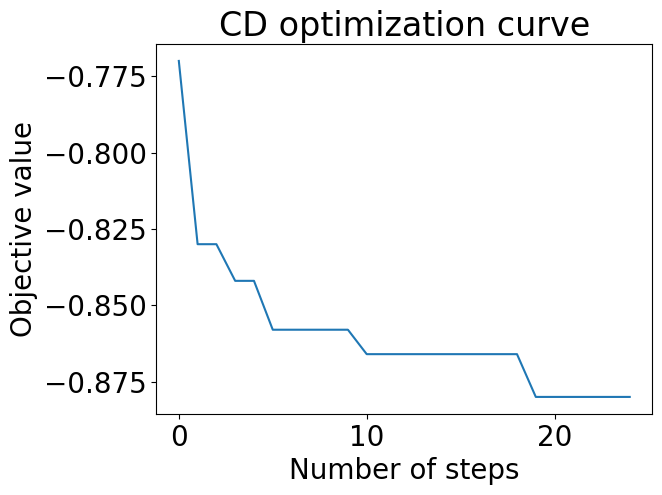

In [ ]:
# %%

plt.plot(fval_history)

plt.xlabel('Number of steps')
plt.ylabel('Objective value')
plt.title('CD optimization curve')

plt.savefig('figs/toy_100n_4q_opt_gpbo_and_cd_opt_curve.jpg',bbox_inches='tight')

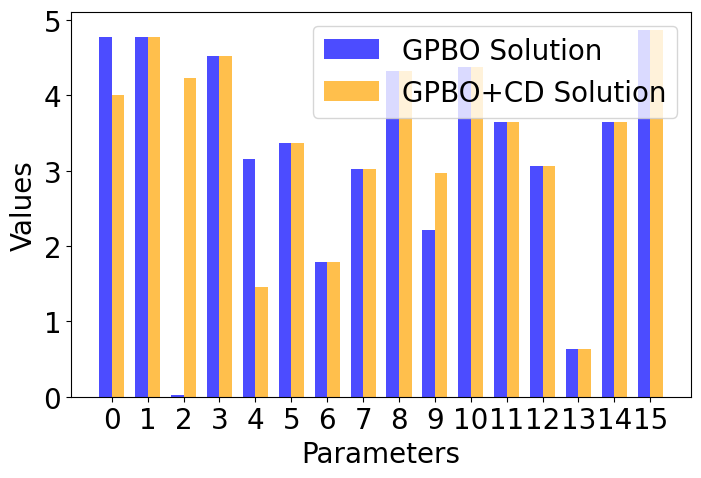

In [ ]:
# %%

bar_width = 0.35

# Positions for bars
x = np.arange(num_params)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(
    x - bar_width / 2,
    v_params,
    bar_width,
    label="GPBO Solution",
    color="blue",
    alpha=0.7,
)
ax.bar(
    x + bar_width / 2,
    v_params_2,
    bar_width,
    label="GPBO+CD Solution",
    color="orange",
    alpha=0.7,
)

# Labels and title
ax.set_xlabel("Parameters")
ax.set_ylabel("Values")
# ax.set_title('Comparison of Two Sets of Solutions')
ax.set_xticks(x)
ax.legend()


plt.savefig("figs/toy_100n_4q_opt_gpbo_and_cd_compare_sols.jpg", bbox_inches="tight")

In [ ]:
# %%

test_scores(v_params_2)

Fitting and scoring for 6 data splits and 288 hyper params
Running in parallel with 50.0 CPUs
Fitting and scoring for train-test splits and best hyper params
AUC test: 0.7677773333135793 train: 1.0
Acc test: 0.6966666666666667 train: 1.0


(np.float64(0.7677773333135793), np.float64(1.0), 0.6966666666666667, 1.0)

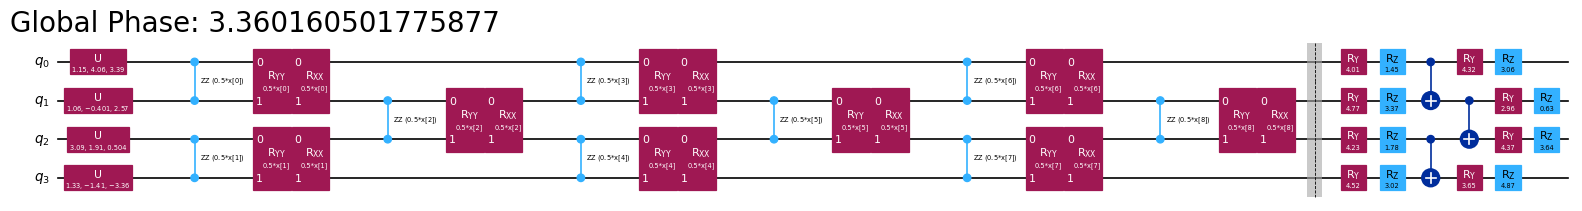

In [ ]:
# %%

# See final circuit
qc = build_combined_circuit(v_params_2, barrier=True)

qc.draw("mpl", scale=0.6, fold=-1, filename="figs/toy_100n_4q_gpbo_and_cd_opt_circ.jpg")